# Ziro Shot Learning

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import datasets, transforms, models

In [32]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
input_dim = 512  # خروجی ResNet18 feature extractor
latent_dim = 64
batch_size = 128
epochs = 20
num_seen_classes = 8
num_unseen_classes = 2

In [66]:
all_classes = list(range(10))
random.shuffle(all_classes)
seen_classes = all_classes[:num_seen_classes]
unseen_classes = all_classes[num_seen_classes:]

print('Seen', seen_classes, 'Unseen', unseen_classes)

Seen [8, 0, 2, 7, 9, 3, 6, 4] Unseen [5, 1]


In [67]:
def filter_by_class(dataset, classes):
    indices = [i for i, (_, label) in enumerate(dataset) if label in classes]
    return Subset(dataset, indices)

train_seen = filter_by_class(trainset, seen_classes)
test_unseen = filter_by_class(testset, unseen_classes)

train_loader = DataLoader(train_seen, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_unseen, batch_size=batch_size, shuffle=False)

In [68]:
classes = train_loader.dataset.dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

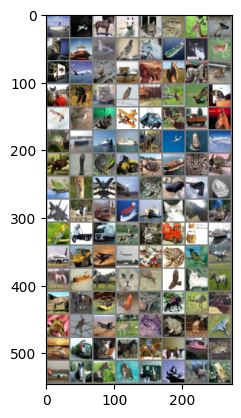

ship  airplane horse horse cat   bird  deer  deer  cat   ship  bird  bird  horse ship  cat   deer  truck airplane bird  airplane frog  horse horse deer  horse frog  cat   bird  horse deer  deer  cat   airplane bird  cat   airplane truck deer  truck horse frog  ship  ship  ship  deer  airplane ship  airplane deer  cat   frog  truck bird  ship  cat   airplane frog  deer  airplane airplane frog  bird  airplane ship  airplane horse truck ship  ship  cat   horse frog  bird  truck truck deer  bird  truck cat   ship  airplane truck airplane airplane horse frog  bird  airplane horse ship  horse cat   deer  bird  cat   horse horse horse ship  bird  frog  horse bird  deer  frog  bird  airplane deer  frog  frog  cat   airplane airplane truck cat   horse horse cat   ship  frog  airplane horse horse cat   truck deer  deer  frog 


In [69]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [70]:
train_loader = DataLoader(train_seen, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_unseen, batch_size=batch_size, shuffle=False)

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [73]:
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # حذف لایه‌ی آخر (FC)
resnet.to(device)
resnet.eval()

def extract_features(images):
    with torch.no_grad():
        feats = resnet(images).view(images.size(0), -1)
    return feats

d:\Pouya Git\advance_computer_vision\ZSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Pouya Git\advance_computer_vision\ZSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
class VAE_lite(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE_lite, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.fc2 = nn.Linear(latent_dim, 256)
        self.fc3 = nn.Linear(256, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [87]:
def vae_lite_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

vae = VAE_lite(input_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [91]:
class VAE(nn.Module):
    def __init__(self, input_size=(32, 32), kernel_size=4, stride=2, padding=1):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)  # input: 3x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)  # output: 64x8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)  # output: 128x4x4
        
        # Calculate the output size of the last convolution layer dynamically based on input size
        conv_out_size = self._get_conv_output(input_size)
        
        self.fc1 = nn.Linear(conv_out_size, 256)
        self.fc2_mu = nn.Linear(256, 64)  # Mean of latent space
        self.fc2_logvar = nn.Linear(256, 64)  # Log variance of latent space
        
        # Decoder
        self.fc3 = nn.Linear(64, 256)
        self.fc4 = nn.Linear(256, 128 * 4 * 4)
        
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)  # output: 64x8x8
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)  # output: 32x16x16
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)  # output: 3x32x32

    def _get_conv_output(self, shape):
        # Dummy tensor to calculate the shape after convolutions
        out = torch.zeros(1, *shape)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        return int(torch.prod(torch.tensor(out.size())))  # Total number of elements after convolutions

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        h = F.relu(self.fc4(h))
        h = h.view(h.size(0), 128, 4, 4)  # Reshape to 128x4x4
        h = F.relu(self.deconv1(h))
        h = F.relu(self.deconv2(h))
        return torch.sigmoid(self.deconv3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [92]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

vae = VAE(input_size=(64, 64), kernel_size=5, stride=1, padding=2).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

RuntimeError: Given groups=1, weight of size [32, 3, 5, 5], expected input[1, 1, 64, 64] to have 3 channels, but got 1 channels instead

In [89]:
print("Training VAE on seen class features...")
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        feats = extract_features(imgs)

        recon, mu, logvar = vae(feats)
        loss = vae_loss(recon, feats, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")

Training VAE on seen class features...


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 512]

In [77]:
print("Generating synthetic features for unseen classes...")
vae.eval()
synthetic_features = []
synthetic_labels = []

samples_per_class = 200

for cls in unseen_classes:
    for _ in range(samples_per_class):
        z = torch.randn(1, latent_dim).to(device)
        fake_feat = vae.decode(z).detach().cpu()
        synthetic_features.append(fake_feat)
        synthetic_labels.append(cls)

synthetic_features = torch.cat(synthetic_features, dim=0)
synthetic_labels = torch.tensor(synthetic_labels)

Generating synthetic features for unseen classes...


In [78]:
print("Training classifier on synthetic features...")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(synthetic_features.numpy(), synthetic_labels.numpy())

Training classifier on synthetic features...


LogisticRegression(max_iter=1000)

In [80]:
print("Evaluating on real unseen class features...")
real_feats = []
real_labels = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    feats = extract_features(imgs).cpu()
    real_feats.append(feats)
    real_labels.append(labels)

real_feats = torch.cat(real_feats, dim=0)
real_labels = torch.cat(real_labels, dim=0)

preds = clf.predict(real_feats.numpy())
acc = accuracy_score(real_labels.numpy(), preds)

print(f"Zero-Shot Accuracy on Unseen Classes: {acc * 100:.2f}%")
print(preds)

Evaluating on real unseen class features...
Zero-Shot Accuracy on Unseen Classes: 43.70%
[5 1 1 ... 5 1 5]
